Table of Contents
<div id="toc"></div>

In [12]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Analysis
## Data Exploration

In [11]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# For plotting
import seaborn as sns
sns.set_style("white")

loading the data

In [17]:
df = pd.read_csv('creditcard.csv')
df[:].head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
df.iloc[:5,::-1]

,Class,Amount,V28,V27,V26,V25,V24,V23,V22,V21,...,V9,V8,V7,V6,V5,V4,V3,V2,V1,Time
0,0,149.62,-0.021053,0.133558,-0.189115,0.128539,0.066928,-0.110474,0.277838,-0.018307,...,0.363787,0.098698,0.239599,0.462388,-0.338321,1.378155,2.536347,-0.072781,-1.359807,0.0
1,0,2.69,0.014724,-0.008983,0.125895,0.167170,-0.339846,0.101288,-0.638672,-0.225775,...,-0.255425,0.085102,-0.078803,-0.082361,0.060018,0.448154,0.166480,0.266151,1.191857,0.0
2,0,378.66,-0.059752,-0.055353,-0.139097,-0.327642,-0.689281,0.909412,0.771679,0.247998,...,-1.514654,0.247676,0.791461,1.800499,-0.503198,0.379780,1.773209,-1.340163,-1.358354,1.0
3,0,123.50,0.061458,0.062723,-0.221929,0.647376,-1.175575,-0.190321,0.005274,-0.108300,...,-1.387024,0.377436,0.237609,1.247203,-0.010309,-0.863291,1.792993,-0.185226,-0.966272,1.0
4,0,69.99,0.215153,0.219422,0.502292,-0.206010,0.141267,-0.137458,0.798278,-0.009431,...,0.817739,-0.270533,0.592941,0.095921,-0.407193,0.403034,1.548718,0.877737,-1.158233,2.0


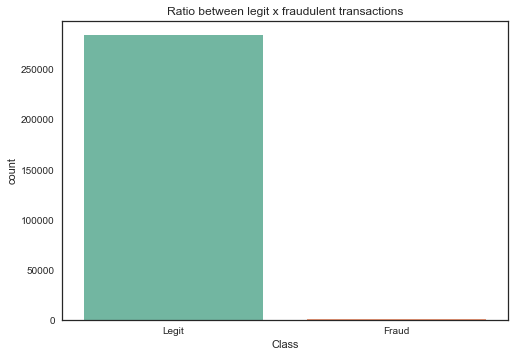

In [46]:
fig = plt.figure()

sns.countplot(df.Class, palette="Set2")
plt.xticks([0,1], ['Legit', 'Fraud'])
plt.title('Ratio between legit x fraudulent transactions')

fig.savefig('fig2 ratio-legitxfraud.png')

plt.show()